In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
import seaborn as sns

#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 22

In [2]:
astropy.__version__

'3.2.1'

In [3]:
fits_file = "https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo206135809-c03_llc.fits"

In [4]:
fits.getdata(fits_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

In [5]:
with fits.open(fits_file, mode="readonly") as hdulist:
    k2_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    sap_errors = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err = hdulist[1].data['PDCSAP_FLUX_ERR']

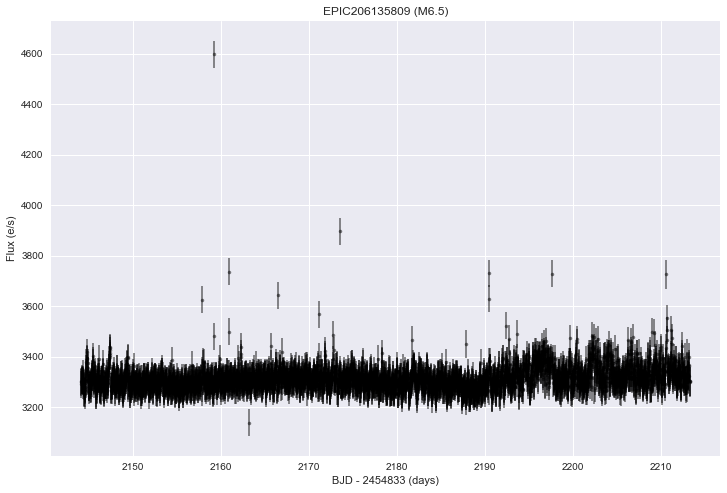

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

# Plot the timeseries in black circles.
#ax.plot(k2_bjds, pdcsap_fluxes, 'ko')
ax.errorbar(k2_bjds, pdcsap_fluxes, 
             yerr=pdcsap_fluxes_err*10, fmt='.', color='k', alpha=0.5)

ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (M6.5)')
plt.savefig('Figures/EPIC206135809_lc.png')

In [16]:
#Filtering nans from data
flux = pdcsap_fluxes[(~np.isnan(pdcsap_fluxes)) & (~np.isnan(k2_bjds))][:500]
flux1 = flux.copy()
#pdcsap_fluxes[np.where(np.isnan(pdcsap_fluxes) == False)[0]]
fluxerr = pdcsap_fluxes_err[np.where(np.isnan(pdcsap_fluxes_err) == False)[0]][:500]
bjd = k2_bjds[np.where((np.isnan(k2_bjds) == False) & (np.isnan(pdcsap_fluxes) == False))[0]][:500]

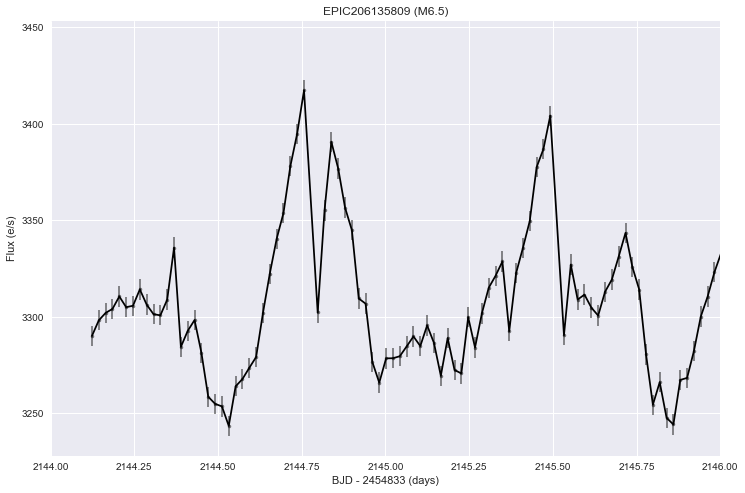

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
plt.errorbar(bjd, flux, yerr=fluxerr, fmt='k.',alpha=0.5)
plt.plot(bjd,flux,c='k')
ax.set_xlim(2144,2146)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (M6.5)')

plt.savefig('Figures/EPIC206135809_lc.png')

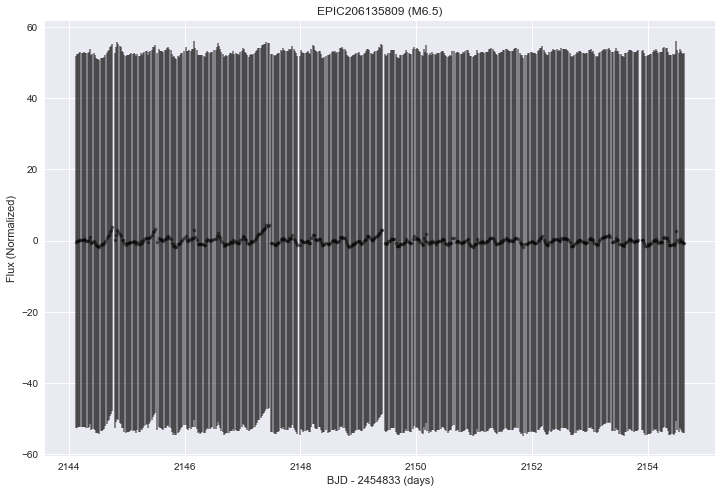

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

mu_n = 0
sig_n = 1
fluxn = mu_n + (flux-np.mean(flux)) * (sig_n / np.std(flux))

plt.errorbar(bjd, fluxn, yerr=fluxerr*10, fmt='k.',alpha=0.5)
#ax.set_ylim(3000,3600)
ax.set_ylabel("Flux (Normalized)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (M6.5)')

In [19]:
np.mean(fluxn), np.std(fluxn)

(-9.0789797e-07, 1.0)

In [20]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [31]:
#Some borrowed code (from http://forrestbao.blogspot.com/2014/07/signal-filtering-using-inverse-fft-in.html)
#that does the FFT filtering with scipy:

def bandpass_ifft(X, Low_cutoff, High_cutoff, F_sample, M=None, inv=False):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    F_sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    
    #import scipy, numpy
    if M == None: # if the number of points for FFT is not specified
        M = X.size # let M be the length of the time series
    Spectrum = scipy.fft(X, n=M)
    #scipy.fft?
    [Low_cutoff, High_cutoff, F_sample] = map(float, [Low_cutoff, High_cutoff, F_sample])
    
    #Convert cutoff frequencies into indices in spectrum array
    #[Low_point, High_point] = map(lambda F: F/F_sample * M/2 , [Low_cutoff, High_cutoff])# the division by 2 is because the spectrum is symmetric 
    
    #Filtering
    
    if inv == True:
        Filtered_spectrum = [Spectrum[i] if i <= Low_cutoff or i >= High_cutoff else 0.0 for i in range(M)]
   
    else:
        Filtered_spectrum = [Spectrum[i] if i >= Low_cutoff and i <= High_cutoff else 0.0 for i in range(M)] 
        
    
    Filtered_spectrum = Spectrum * invgaussian(High_cutoff-Low_cutoff,1,np.linspace(0,len(Spectrum),1))
        
    Filtered_signal = scipy.ifft(Filtered_spectrum)  # Construct filtered signal
    print(Filtered_signal[0:10])
    plt.plot(Filtered_signal)
    #Filtered_signal = np.zeros_like(Filtered_signal)
    return Spectrum, Filtered_spectrum, Filtered_signal, Low_cutoff, High_cutoff

[-0.34378931+1.95399252e-16j -0.08764885+4.36983782e-16j
  0.0356447 +4.57411886e-16j  0.10129209-3.17967874e-16j
  0.3063519 +6.69050564e-18j  0.12950984-4.67632453e-16j
  0.15335833+1.60086512e-17j  0.42214867+7.20319324e-16j
  0.17178988+3.59478426e-16j  0.0142408 +7.17355840e-17j]


/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


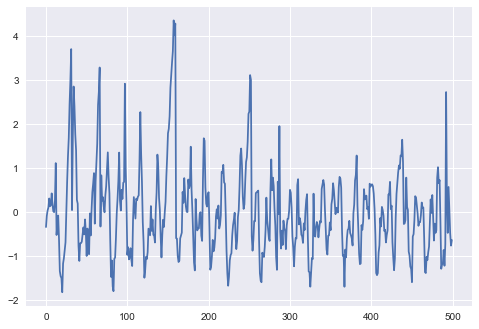

In [32]:
Low_cutoff, High_cutoff, F_sample = 25, 75, 500
Spectrum, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(fluxn, Low_cutoff, High_cutoff, 
                                                                                    F_sample, M=len(bjd), inv=True)

Add inv gaussian filter:
   - mu = bin(freq_telescope)
   - sigma
   - 1 - g(mu, sigma)

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


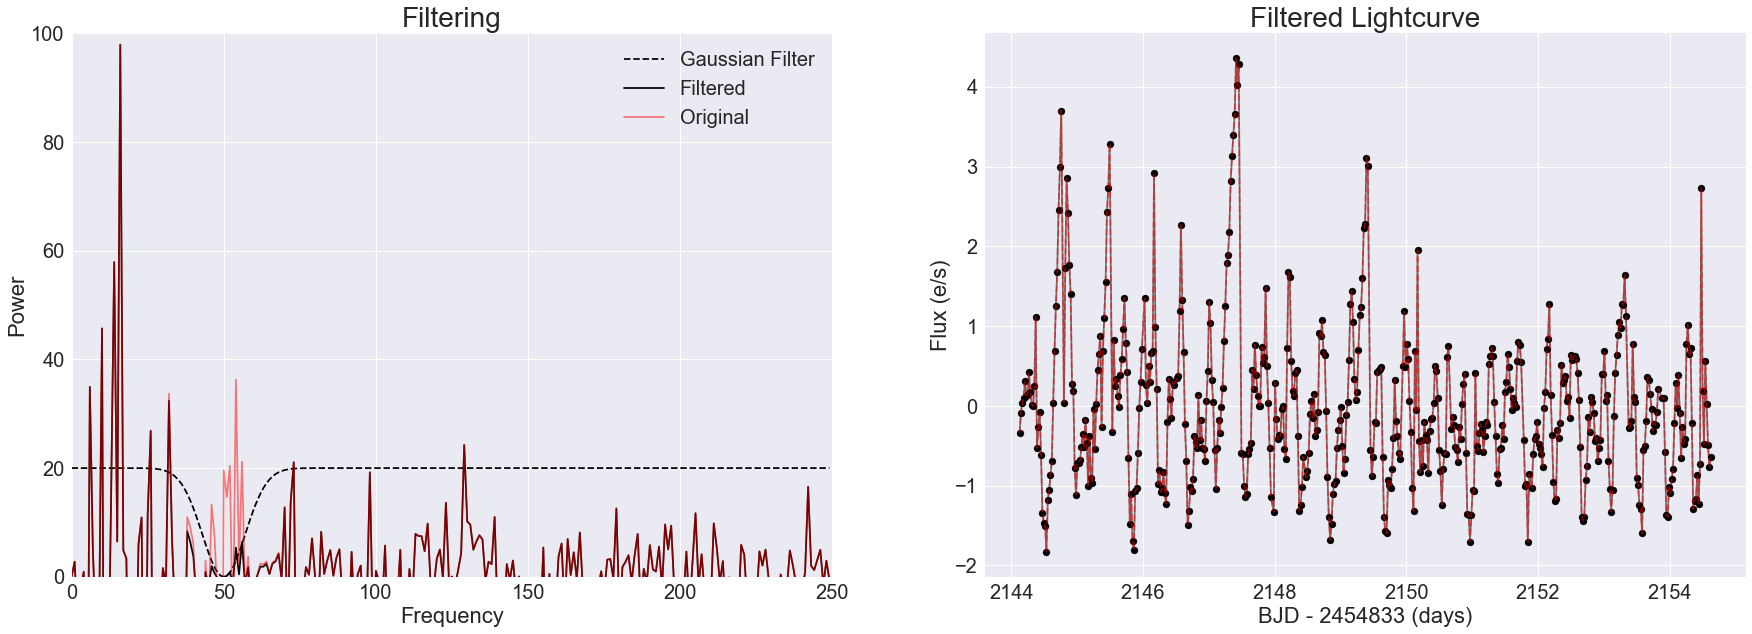

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = np.ravel(axs)
plt.rcParams.update({'font.size': 36})

axs[0].set_title('Filtering',fontsize=28)
axs[1].set_title('Filtered Lightcurve',fontsize=28)

axs[0].set_xlim(0,F_sample/2)
axs[0].set_ylim(0,100)

axs[0].set_xlabel('Frequency',fontsize=22)
axs[0].set_ylabel('Power',fontsize=22)

axs[1].set_xlabel('BJD - 2454833 (days)',fontsize=22)
axs[1].set_ylabel('Flux (e/s)',fontsize=22)

axs[0].tick_params(labelsize=20)
axs[1].tick_params(labelsize=20)

m = 50
s = 10

axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, 
         invgaussian(m, s, np.fft.fftfreq(len(bjd))[:250]*F_sample)*20, c='k', ls='--', label='Gaussian Filter')
axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, 
         Spectrum[:250]*invgaussian(m, s, np.fft.fftfreq(len(bjd))[:250]*F_sample), c='k',label='Filtered')
axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, Spectrum[:250], c='r',label='Original', alpha=0.5)

#axs[0].plot(np.fft.fftfreq(len(bjd))[:250]*F_sample, abs(Spectrum[:250]), c='k')
#axs[0].axvspan(Low_cutoff, High_cutoff, color='red', alpha = 0.25)
#axs[0].axvspan(High_cutoff, 250, color='green', alpha = 0.25)
#axs[0].axvspan(-250,Low_cutoff, color='green', alpha = 0.25)
axs[1].scatter(bjd, Filtered_signal, color='k')
axs[1].plot(bjd, Filtered_signal, color='k',alpha=0.5)
axs[1].plot(bjd, (flux1 - flux1.mean()) / flux1.std(),'r--',alpha=0.5)

axs[0].legend(fontsize=20)

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


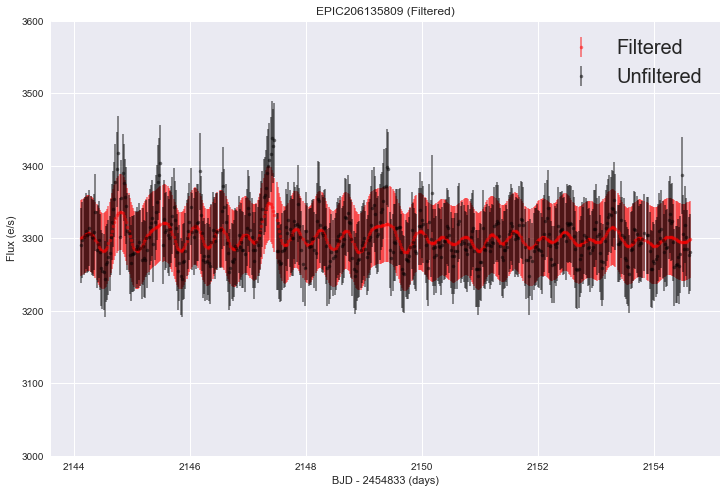

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
plt.errorbar(bjd, Filtered_signal, yerr=fluxerr*10, fmt='r.',alpha=0.5,label='Filtered')
ax.set_ylim(3000,3600)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (Filtered)')
ax.errorbar(bjd, flux, yerr=fluxerr*10, fmt='k.',alpha=0.5,label='Unfiltered')
#plt.savefig('Figures/EPIC206135809_lc.png')
plt.legend(fontsize=20)

In [ ]:
#Tweak bandpass to allow inverse window
#Run on whole code

In [46]:
#Filtering nans from data
flux = pdcsap_fluxes[(~np.isnan(pdcsap_fluxes)) & (~np.isnan(k2_bjds))]#[:500]
#pdcsap_fluxes[np.where(np.isnan(pdcsap_fluxes) == False)[0]]
fluxerr = pdcsap_fluxes_err[np.where(np.isnan(pdcsap_fluxes_err) == False)[0]]#[:500]
bjd = k2_bjds[np.where((np.isnan(k2_bjds) == False) & (np.isnan(pdcsap_fluxes) == False))[0]]#[:500]

In [47]:
Low_cutoff, High_cutoff, F_sample = 0, 50, 500
Spectrum, Filtered_spectrum, Filtered_signal, Low_point, High_point = bandpass_ifft(flux, Low_cutoff, High_cutoff, 
                                                                                    F_sample, M=len(bjd))

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


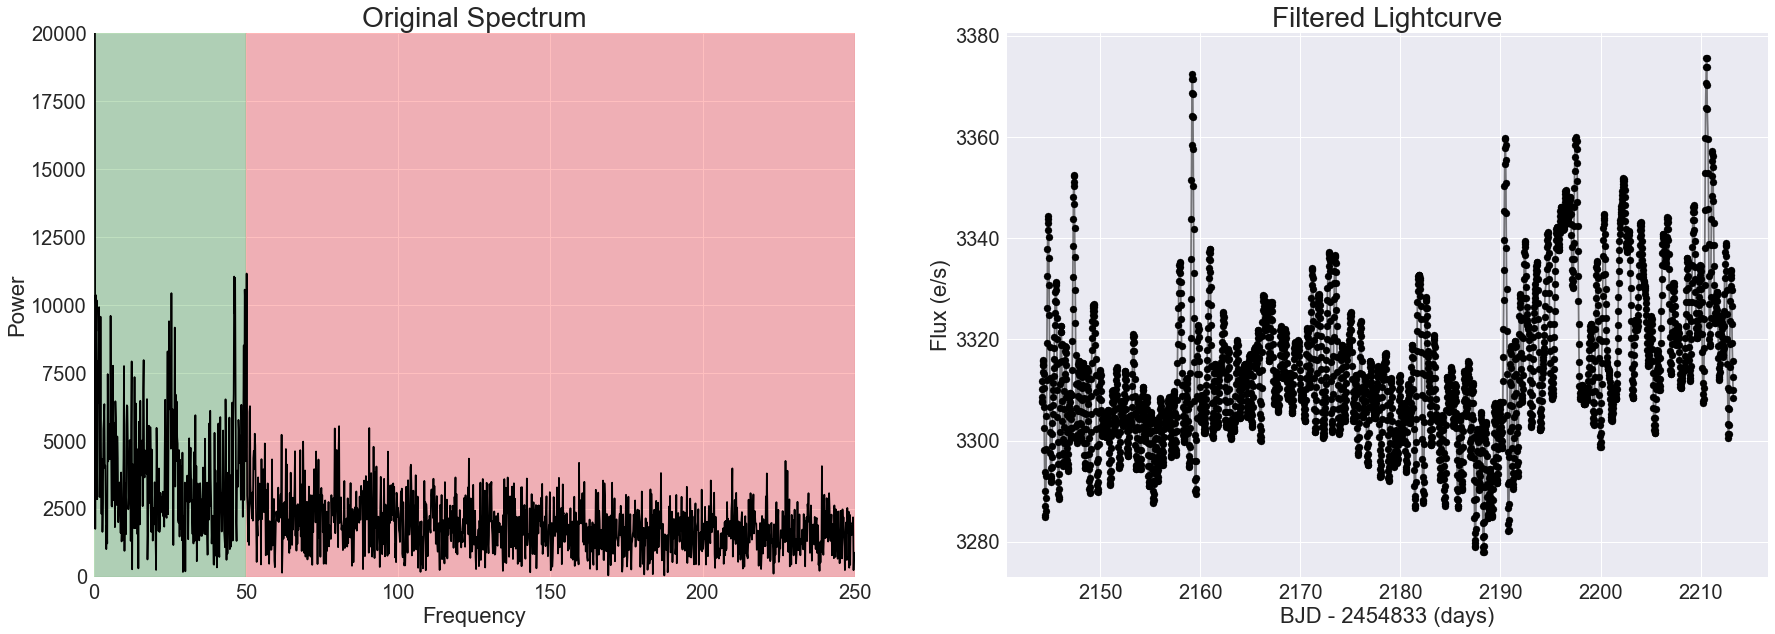

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = np.ravel(axs)
plt.rcParams.update({'font.size': 36})

axs[0].set_title('Original Spectrum',fontsize=28)
axs[1].set_title('Filtered Lightcurve',fontsize=28)

axs[0].set_xlim(0,F_sample/2)
axs[0].set_ylim(0,20000)

axs[0].set_xlabel('Frequency',fontsize=22)
axs[0].set_ylabel('Power',fontsize=22)

axs[1].set_xlabel('BJD - 2454833 (days)',fontsize=22)
axs[1].set_ylabel('Flux (e/s)',fontsize=22)

axs[0].tick_params(labelsize=20)
axs[1].tick_params(labelsize=20)

axs[0].plot(np.fft.fftfreq(len(bjd))[:int(len(bjd)/2)]*F_sample, abs(Spectrum[:int(len(bjd)/2)]), c='k')
axs[0].axvspan(Low_cutoff, High_cutoff, color='green', alpha = 0.25)
axs[0].axvspan(High_cutoff, 250, color='red', alpha = 0.25)
axs[1].scatter(bjd, Filtered_signal, color='k')
axs[1].plot(bjd, Filtered_signal, color='k',alpha=0.5)

/Users/Riley/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Container object of 3 artists>

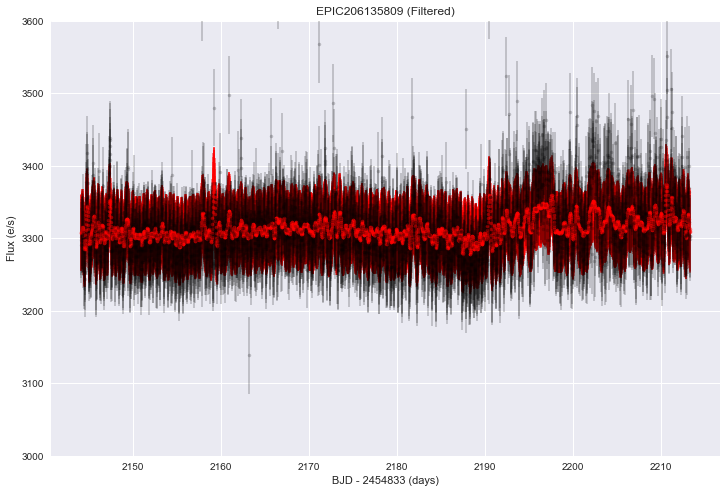

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)
plt.errorbar(bjd, Filtered_signal, yerr=fluxerr*10, fmt='r.',alpha=0.5)
ax.set_ylim(3000,3600)
ax.set_ylabel("Flux (e/s)")
ax.set_xlabel("BJD - 2454833 (days)")
ax.set_title('EPIC206135809 (Filtered)')
ax.errorbar(bjd, flux, yerr=fluxerr*10, fmt='k.',alpha=0.2)
#plt.savefig('Figures/EPIC206135809_lc.png')